# Introduction

We have learned how CNNs will take an input image, and through a series of layers, transform that input into an output that's much smaller in the x, y dimensions, but much greater in depth. Along the way, the CNN is discarding spatial information from the input image and isolating high level information about its content. Some of this structure can also be thought of as a kind of data compression; compressing from an image into something like a feature vector, which is basically a feature map produced after an input has gone through a series of layers squished into a vector shape. 

This is part fo what makes up something called an autoencoder, which is what we will learn about this lesson. An autoencoder has two main components: an encoder that compresses some input data, and a decoder that reconstructs data form the compressed representation. Why is htis kind of structure even useful? 

It ends up being useful in a number of cases. Autoencoders are used in a traditional data compression sense, in that they can learn to reduce the dimensionality of any input. Then, anyone can use a compressed representation to share it, or view it and so on, faster than they could with the original input. We might think of something like a jpg or mp3 file type, which contain explicit rules for compressing images and audio. The difference is that an autoencoder learns efficient data compression and decompression functions instead of having them designed, encoded by a human. 

Autoencoders have shown the most promise in image denoising techniques and in filling in missing data. This structure will also come up again as we learn about generative models that can take in an image and transform it into a related space such as form gray scale to color or from low to high resolution images. 

The encoder and decodeer are both built with neural networks. Generally, the whole network is trained by minimizing the difference between the input and the output. In that way, the middle layer will be a compressed representation of the input data from which we can reconstruct the original data. 

<img src="assets/Autoencoders.png">

The key aspect of an autoencoder is its ability to compress an image such that its content is still maintained. Then later, we may be able to use this compressed representation to generate something else. We will show how to build autoencoders in PyTorch. We will start with a simple example where we will compress images. Then, since this is ImageData, we will improve it by using convolutional layers.

So, let's be defining and training an autoencoder!

# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset, which has images of 28x28x1 array with a total number of 784 pixels. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

<img src='assets/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. Compressed data is often cheaper to store in data centers and faster to share across Wi-Fi connected devices. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

<img src='assets/denoising.png' width=60%/>


The idea is that we define our encoder and decoder as neural networks. Then, we train this complete autoencoder by passing in an original image and getting back as output a reconstructed image. We can then compare the original with the reconstruction. We want the original and reconstructed image to be as close as possible. So, our loss will actually be comparing these pixel values and measuring the difference between the original and reconstructed images. Once this whole network is trained, we should have a working encoder and decoder portion of a network, and we will be able to use either part to either compress or decompress a certain image. 

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

We are only defining train and test loaders here, and that is because in this case, we really just want to get our training loss as low as possible. This is not a typical classification task, and validation sets are really most useful when we are trying to predict a quantity like a class. 

In [2]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

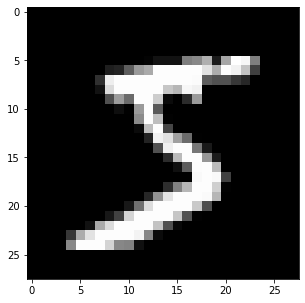

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of **one linear layer**. The units that connect the encoder and decoder will be the _compressed representation_. The decoder will also be made of one linear layer that will up sample or increase the dimension of the compressed representation. We want this layer to output a vector of length 784. Later, we will reshape this vector output into a 28x28 reconstructed image, and then we will be able to compare these two. 

Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values that match this input value range.

<img src='assets/simple_autoencoder.png' width=50% />


#### TODO: Build the graph for the autoencoder in the cell below. 
> The input images will be flattened into 784 length vectors. The targets are the same as the inputs. 
> The encoder and decoder will be made of two linear layers, each.
> The depth dimensions should change as follows: 784 inputs > **encoding_dim** > 784 outputs.
> All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

**The compressed representation should be a vector with dimension `encoding_dim=32`.**

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.fce1 = nn.Linear(28 * 28, 256)
        self.fce2 = nn.Linear(256, encoding_dim)
        ## decoder ##
        self.fcd1 = nn.Linear(encoding_dim, 256)
        self.fcd2 = nn.Linear(256, 784)
        

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        x = F.relu(self.fce1(x))
        x = F.relu(self.fce2(x))
        x = F.relu(self.fcd1(x))
        x = F.sigmoid(self.fcd2(x))
        
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fce1): Linear(in_features=784, out_features=256, bias=True)
  (fce2): Linear(in_features=256, out_features=32, bias=True)
  (fcd1): Linear(in_features=32, out_features=256, bias=True)
  (fcd2): Linear(in_features=256, out_features=784, bias=True)
)


---
## Training

Here We'll write a bit of code to train the network. We are not too interested in validation here, so we'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing _quantities_ rather than probabilistic values. So, in this case, We'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

We also use `Adam` optimizer simply because it is been proven to work better in these scenarios.

Otherwise, this is pretty straightfoward training with PyTorch. We flatten our images, pass them into the autoencoder, and record the training loss as we go.

In [6]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In the next code, note we use images, we are actually not interested in any labels only in original images and the reconstructions. Then we flatten these images and then pass those vectors to our model.

Our model returns recosntructed image outputs. Then finally, we are comparing the input images and this output reconstructed image. So our loss is actually telling us how good of a reconstructed image our model has produced. 


In [7]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/Users/mb78200/opt/anaconda3/envs/my_p3_env/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.502579
Epoch: 2 	Training Loss: 0.303383
Epoch: 3 	Training Loss: 0.271715
Epoch: 4 	Training Loss: 0.246890
Epoch: 5 	Training Loss: 0.232441
Epoch: 6 	Training Loss: 0.223691
Epoch: 7 	Training Loss: 0.217513
Epoch: 8 	Training Loss: 0.212696
Epoch: 9 	Training Loss: 0.208922
Epoch: 10 	Training Loss: 0.205831
Epoch: 11 	Training Loss: 0.203217
Epoch: 12 	Training Loss: 0.201044
Epoch: 13 	Training Loss: 0.199142
Epoch: 14 	Training Loss: 0.197452
Epoch: 15 	Training Loss: 0.195934
Epoch: 16 	Training Loss: 0.194628
Epoch: 17 	Training Loss: 0.193400
Epoch: 18 	Training Loss: 0.192255
Epoch: 19 	Training Loss: 0.191229
Epoch: 20 	Training Loss: 0.190259


We saw that the biggest decreases happened at the start of training, and the minor decreases around epoch 13 or so. So, if we train for loger than 20 epochs, we couldn't be sure if we would have seen much of an improvement, but this loss is only one way to check how well our model is doing. 

For classification model recall, we would often look at classification accuracy, but here the task is a little different, this whole time we are comparing original input images to the recostructions. So, a better way to see how our encoder is doing is to look directly at those reconstructions.

## Checking out the results

Below, We are loading in a batch of test data and we care only about the images. Then, we flattened those test images and pass them to our model to get some reconstructions. Finally, we resize that output, so that is reshaped into a 28x28 image, and that code displays 10 original images and their 10 reconstructions underneath them.

We've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

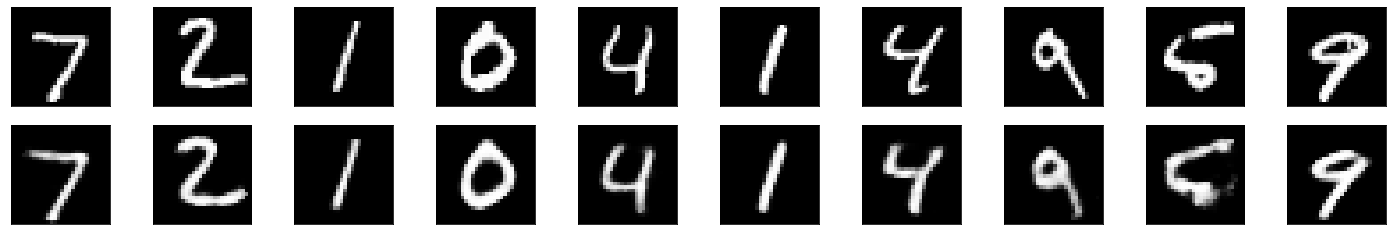

In [8]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

# Learnable Upsampling

Now that we have seen how to build an autoencoder out of linear layers, let's improve on this model using convolutional layers. Convolutional layers give us a way to preserve spatial information. So, generally, they are part of a better and more elegant solution for encoding and decoding images. The encoder portion of an autoencoder is something that we have seen before in our notebook on CNNs. 

It is typically made of a series of convolutional and maxpooling layers that downsample the spatial dimensions of an input image. So, we know roughly how to get from an input to a compressed representation already. The decoder is something we haven't really seen before. How can we go from a compressed representation to a reconstructed image?

In our example above we have seen that we can just define a linear layer to transform any number of inputs into our desired output size, and so we could easily reverse the encoder steps. Here, with an input image instead of a vector, there are a couple of approaches we might take, but the end goal is the same. We want to reverse the downsampling process that happened in the encoder. We want to increase the spatial dimensions of a compressed input to produce a reconstructed image that has the same shape as the original input. 

So, instead of down sampling using maxpooling, we can imagine trying to upsample an image by unpooling the pixel values in an input. We could use an interpolation technique like nearest neighbors or another kind of linear interpolation. Nearest neighbors expands a given area by copying over a single pixel value from an input image to, say, a 2x2 in the larger output image. 

<img src="assets/nearestNeighbors.png">

If we have ever try to enlarge a low resolution image this upsampling is usually what happens. But interpolation is a fairly crude way to upsample an image. In the case of nearest neighbors, we are just copying over existing values. But a realistic larger image is likely to have more variety in pixel values, and so there may be better way to upsample its image. 

So, we could also try to learn how to best upsample an image. If we want our network to learn how to upsample, we can use a transpose convolutional layer. This layer does not use a predefined interpolation method, instead it has learnable parameters. We will sometimes hear these referred to as deconvolutional layers but it is not strictly undoing a convolution step. We find it most helpful to think of transpose convolution as a way to upsample existing input values using filter weights, in a way that is similar to traditional convolution. 

Let's get into the math behind a transpose convolutional layer!

# Transpose convolutions

Imagine that we have an input image that is 4x4 pixels, small but good for an example. We want to produce an output filtered image that is the same size. This is our usual case, and we have seen that we can use a 3x3 kernel and a padding of one to get this result. Convolution tell us to multiply each pixel value in the input image by the weights of the overlaid kernel, and then add them all up to get the resultant output pixel value. We typically have a stride of one to do this for every pixel in the input image, as shown at next:

<img src="assets/ConvolutionSimple.png">

But what if we had a stride of two? Well our kernel would move to the right and down by 2x2 pixels at a time instead of one, and the output will be a 2x2 filtered image. The filter is moving two pixels for every one pixel in the output image, and it turns out that the stride value is roughly the radio of the input to output dimensions. In this way, a convolutional operation can actually down sample an image.

<img src="assets/ConvolutionalStrideTo2.png">

Now, keep this stride value of two in mind as we show how transpose convolution reverses this process. It can take a single pixel from a 2x2 image, place a 3x3 kernel over it, then multiply that one pixel value by one kernel weights to get a resultant 3x3 pixel area. Say we do this whith the first pixel, and we get a 3x3 output area with some center. Then, we try to do the same thing for the second pixel. We will assume that our stride is two in the output, so the center of the generated area will be two to the right of two center of the 3x3 area. 

<img src="assets/CNNtoTransposeStep1.png">

Now, transpose convolution will produce another 3x3 area, one that overlaps with the initial one. In the case of overlap, these one will just be summed together. If we do this for all four of the input pixels, it will give a 5x5 resultant area.

<img src="assets/CNNtoTransposeStep2.png">

There are some options to add or substract padding from this output, but the most common case, it will use a 2x2 filter and a stride of two to double the x and y dimensions of two input. The weights in the kernel here are learned much like in a convolutional layer. Only this time, the purpose is to learn effective upsampling.

<img src="assets/CNNTransposeStride.png">

# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset. 

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

<img src='assets/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or other kinds of reconstruction and transformation!

<img src='assets/denoising.png' width=60%/>

Let's get started by importing our libraries and getting the dataset.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [2]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

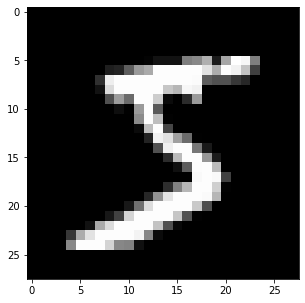

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Convolutional  Autoencoder

#### Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. 

#### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation. A schematic of the network is shown below.

<img src='assets/conv_enc_1.png' width=640px>

Here our final encoder layer has size 7x7x4 = 196. The original images have size 28x28 = 784, so the encoded vector is 25% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, in fact, you're encouraged to add additional layers to make this representation even smaller! Remember our goal here is to find a small representation of the input data.

### Transpose Convolutions, Decoder

This decoder uses **transposed convolutional** layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d). 

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. 

> We'll show this approach in another notebook, so you can experiment with it and see the difference.


#### TODO: Build the network shown above. 
> Build the encoder out of a series of convolutional and pooling layers. 
> When building the decoder, recall that transpose convolutional layers can upsample an input by a factor of 2 using a stride and kernel_size of 2. 

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. Since this is a convlutional autoencoder, our images _do not_ need to be flattened before being passed in an input to our model.

In [17]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.507934
Epoch: 2 	Training Loss: 0.249447
Epoch: 3 	Training Loss: 0.229215
Epoch: 4 	Training Loss: 0.219722
Epoch: 5 	Training Loss: 0.214376


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. These look a little rough around the edges, likely due to the checkerboard effect we mentioned above that tends to happen with transpose layers.

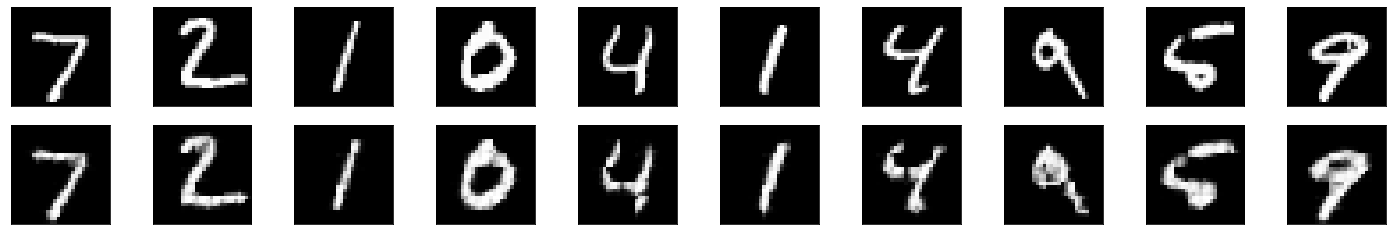

In [19]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

We may notice that we are not using model.train() or eval() here, and that is because none of the layers in this model will change behavior between these modes. So, we could use these modes, but it is not necessary. Evaluation mode affects dropout layers that change dynamically during training, whereas our typical convolutional and maxpooling layers will behave as their weights dictate!


# Upsampling 

Let's take the same convolutional structure than above. The encoder is made of a series of convolutional and maxpooling layers, and our compressed representation is the same, a 7x7x4 output. What we will be changing is how we make the decoder portion. Instead of just including transpose convolutional layers, we are combining nearest neighbor interpolation with normal convolutional layers. 

<img src="assets/convolutional_autoencoder.png">

Nearest neighbor interpolation is just an upsampling method that copies over pixel values fom, say, a 2x2 area to a 4x4 area. So, after the 7x7x4 compressed representation is created by the encoder, we upsample that by a factor of 2 to get a 14x14x4 tensor. Then, we put it through a convolutional layer to increse the depth to 16. Then one more upsample to get to the size we want, 28x28, and one more convolutional layer to get us to the size of the reconstructed output, 28x28x1.

So, basically, we replaced  one transpose convolutional layer with an upsample function and a convolutional layer. The convolutional layer changes the depth of an input and acts as a series of image filters that can learn to cleverly transform the layers in between upsampling functions. 


# Upsampling implementation

In [23]:
# define the NN architecture
class ConvAutoencoderUpsample(nn.Module):
    def __init__(self):
        super(ConvAutoencoderUpsample, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 1, 3, padding=1)
        

    def forward(self, x):
        # add layer, with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decoder 
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `interpolate` in some PyTorch versions
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv4(x))
        # upsample again, output should have a sigmoid applied
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv5(x))
        
        return x

# initialize the NN
modelUpsample = ConvAutoencoderUpsample()
print(modelUpsample)

ConvAutoencoderUpsample(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [24]:
# specify loss function
criterionUpsample = nn.MSELoss()

# specify loss function
optimizerUpsample = torch.optim.Adam(modelUpsample.parameters(), lr=0.001)

In [25]:
# number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizerUpsample.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = modelUpsample(images)
        # calculate the loss
        loss = criterionUpsample(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizerUpsample.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.295072
Epoch: 2 	Training Loss: 0.159160
Epoch: 3 	Training Loss: 0.142892
Epoch: 4 	Training Loss: 0.135696
Epoch: 5 	Training Loss: 0.131345


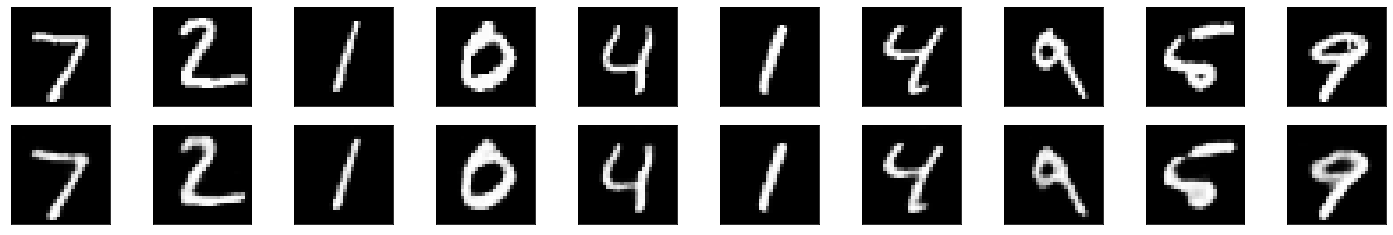

In [26]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = modelUpsample(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Remember, many tasks have multiple solutions, in fact, the best deep learning researchers and learners have investigated a number of options for solutions, different architectures that might offer certain benefits or trade-offs.

# Denoising

Knowing that we know now about convolutional autoencoders, let's challenge ourselves to make a denoising autoencoder. As we know, Autoencoders don't excel at compressing images but they can learn pretty well how to denoise them given a noisy and non noisy set to learn from. The idea is this given an input set of noisy data and a target set of data that's the non noisy image data, the encoder can learn to distill important information from the noisy image and the decoder can learn to produce a non noisy reconstruction. After this is trained, this whole auto encoder should be able to denoise new test data. 

Again we will be loading and visualizing our MNIST dataset, then, we are going to add the speckle noise to the data. This way, we will have a set of noisy images for an encoder to see and set of target images that are without noise. 

Let's define a ConvDenoiser architecture. That architecture will be very similar to the ones we have gone through. Only denoising is a bit of a harder problem. We encorage to increase the depths of our convolutionl layers. Something like starting with a depth of 32 for the depths, instead of 16. It could be useful to add one more convolutional layer to both the encoder and decoder. Basically, more and deeper layers will give us more parameters to recognize patterns with. 

In the training loop, we changed some thing so that we are adding some noisse to our images. Our loss is going to be comparing our reconstructed images with our originals are target non noisy images. 

We even encourage to try to test out the limits of just how much noise we can add to our images. We can imagine using a similar approach for doing something like denoising audio signals and removing static from sound. Go ahead and experiment!

# Denoising Autoencoder

Sticking with the MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to _de_-noise the images.

<img src='assets/autoencoder_denoise.png' width=70%/>

Let's get started by importing our libraries and getting the dataset.

In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

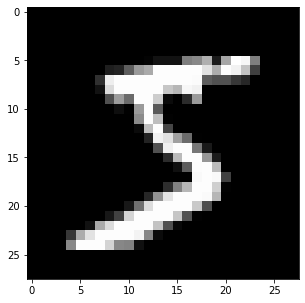

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Denoising

As we've mentioned before, autoencoders like the ones we've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

>**We'll use noisy images as input and the original, clean images as targets.** 

Below is an example of some of the noisy images we generated and the associated, denoised images.

<img src='assets/denoising.png' />


Since this is a harder problem for the network, we'll want to use _deeper_ convolutional layers here; layers with more feature maps. We might also consider adding additional layers. We suggest starting with a depth of 32 for the convolutional layers in the encoder, and the same depths going backward through the decoder.

#### TODO: Build the network for the denoising autoencoder. Add deeper and/or additional layers compared to the model above.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 64), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        # conv layer (depth from 64 --> 32), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv4 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 3, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(32, 64, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.f_conv = nn.Conv2d(64, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # add four hidden layer
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        # compressed representation
        ## decode ##
        
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.f_conv(x))
                
        return x

# initialize the NN
modelDenoiser = ConvDenoiser()
print(modelDenoiser)

ConvDenoiser(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (f_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


---
## Training

We are only concerned with the training images, which we can get from the `train_loader`.

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

In [6]:
# specify loss function
criterionDenoising = nn.MSELoss()

# specify loss function
optimizerDenoising = torch.optim.Adam(modelDenoiser.parameters(), lr=0.001)

In [7]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizerDenoising.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = modelDenoiser(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterionDenoising(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizerDenoising.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/Users/mb78200/opt/anaconda3/envs/my_p3_env/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.072106
Epoch: 2 	Training Loss: 0.756877
Epoch: 3 	Training Loss: 0.700867
Epoch: 4 	Training Loss: 0.673345
Epoch: 5 	Training Loss: 0.655551
Epoch: 6 	Training Loss: 0.642888
Epoch: 7 	Training Loss: 0.632591
Epoch: 8 	Training Loss: 0.625094
Epoch: 9 	Training Loss: 0.618757
Epoch: 10 	Training Loss: 0.613295
Epoch: 11 	Training Loss: 0.608743
Epoch: 12 	Training Loss: 0.605301
Epoch: 13 	Training Loss: 0.602261
Epoch: 14 	Training Loss: 0.598541
Epoch: 15 	Training Loss: 0.596154
Epoch: 16 	Training Loss: 0.593952
Epoch: 17 	Training Loss: 0.592122
Epoch: 18 	Training Loss: 0.589777
Epoch: 19 	Training Loss: 0.588363
Epoch: 20 	Training Loss: 0.587133


## Checking out the results

Here We are adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

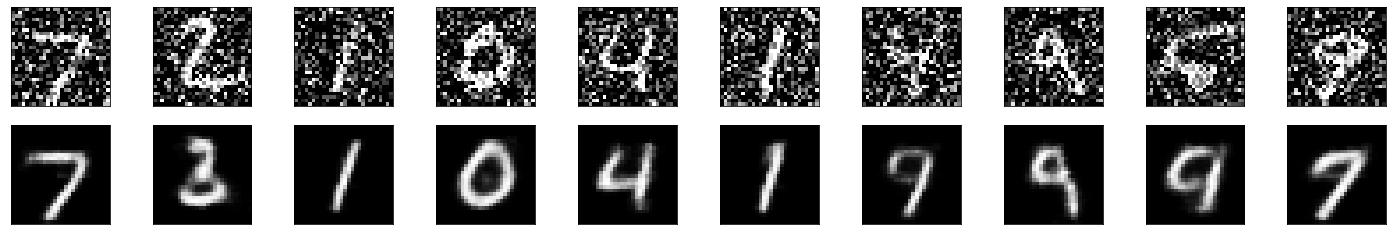

In [8]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = modelDenoiser(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# A second solution

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser2(nn.Module):
    def __init__(self):
        super(ConvDenoiser2, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
modelDenoiser2 = ConvDenoiser2()
print(modelDenoiser2)

ConvDenoiser2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [10]:
# specify loss function
criterionDenoiser2 = nn.MSELoss()

# specify loss function
optimizerDenoiser2 = torch.optim.Adam(modelDenoiser2.parameters(), lr=0.001)

In [11]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizerDenoiser2.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = modelDenoiser2(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterionDenoiser2(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizerDenoiser2.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.929582
Epoch: 2 	Training Loss: 0.635787
Epoch: 3 	Training Loss: 0.578973
Epoch: 4 	Training Loss: 0.550809
Epoch: 5 	Training Loss: 0.535634
Epoch: 6 	Training Loss: 0.526870
Epoch: 7 	Training Loss: 0.519317
Epoch: 8 	Training Loss: 0.512387
Epoch: 9 	Training Loss: 0.507853
Epoch: 10 	Training Loss: 0.503731
Epoch: 11 	Training Loss: 0.500251
Epoch: 12 	Training Loss: 0.496791
Epoch: 13 	Training Loss: 0.492539
Epoch: 14 	Training Loss: 0.488689
Epoch: 15 	Training Loss: 0.485574
Epoch: 16 	Training Loss: 0.481899
Epoch: 17 	Training Loss: 0.477790
Epoch: 18 	Training Loss: 0.473902
Epoch: 19 	Training Loss: 0.471921
Epoch: 20 	Training Loss: 0.469191


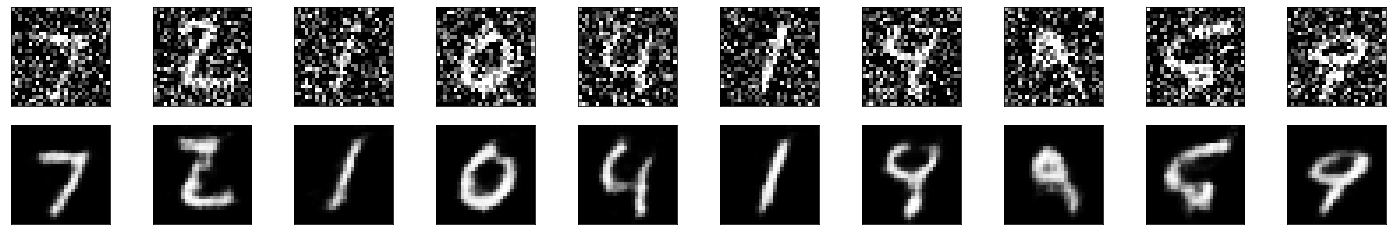

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = modelDenoiser2(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)